## Micrograd demo

In [26]:
# Packages

import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from engine import Value
from nn import Neuron, Layer, MLP
#%matplotlib inline

In [27]:
def trace(root: Value):
    # builds the set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root) # Builds the graph for root sets
    
    # Creates the graphical nodes...
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label=f"{n.label} | {n.data:.4f} | {n.grad:.4f}", shape='record')
        if n._op: 
            # If the node was generated via a mathematical operation, create a node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect it to the associated node...
            dot.edge(uid+n._op, uid)
    # Creates the graphical edges...
    for n1, n2 in edges:
        # connect n1 to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [28]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


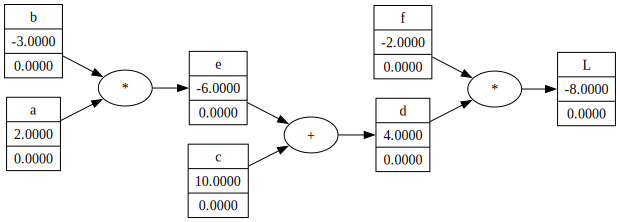

In [29]:
draw_dot(L)

So, in this case, the output of the *forward pass* is $-8.0$.

Note that with <code>Value</code> we can simulate a simple neuron.

![Basic model of a neuron](neuron_model.jpeg)

Le us simulate a simple neuron with:
- two inputs, say $x_1, x_2$;
- two weights, say $w_1, w_2$;
- a bias, say $b$;
- activation function $f(x) = \tanh(x)$.

In [30]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias 
b = Value(6.881373587019, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# the raw neuron (without activatoin function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

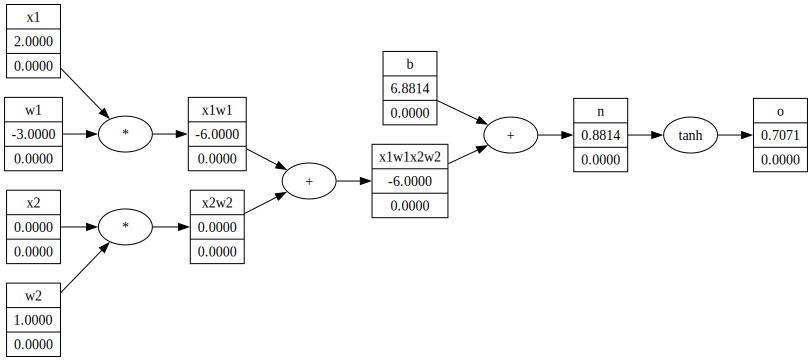

In [31]:
draw_dot(o)

By design all the gradients are $0$. Using the <code>_backward</code> function, we will makwe the back propagation.

Now we want to do the *back propagation* or the *backward pass*.
Observe that, as a base case, we need to put <code>o.grad = 1.0</code>. Why? remember that o.grad = $\frac{do}{do} = 1$ and that, by design, 
when creating a new <code>Value()</code> in <code>engine.py</code>, the gradient is set to zero. If we do not set this base case at one (as it should be), the chain rule, or better the backwar pass, will make all the <code>.grad</code> equal $0$.

In [32]:
o.grad = 1.0 # base case

### Backpropagation by hand: this is just a mental exercise. Later in the notebook, the process will be automated by means of topological ordering.

**BEWARE**: Every cell with the _backward function must be called once only, as the gradients are being summed (+= in the code, not =)

Now, recall that by design, $o = \tanh(n)$. Calling <code>o.backward</code> will compute $\frac{do}{dn}$ and assign it to the <code>grad</code> of the node that, through a certain function (in our case $x \to \tanh(x)$), generated $o$ (in our case $n$).

In [33]:
# o._backward()
# n.grad

In [34]:
# n._backward() # computes do/db and do/dx1w1x2w2

In [35]:
# b._backward() # does nothing. In fact it is not generated through other nodes and so _bacward is defined in the constructor as lambda: None

In [36]:
# x1w1x2w2._backward()

In [37]:
# x1w1._backward()

In [38]:
# x2w2._backward()

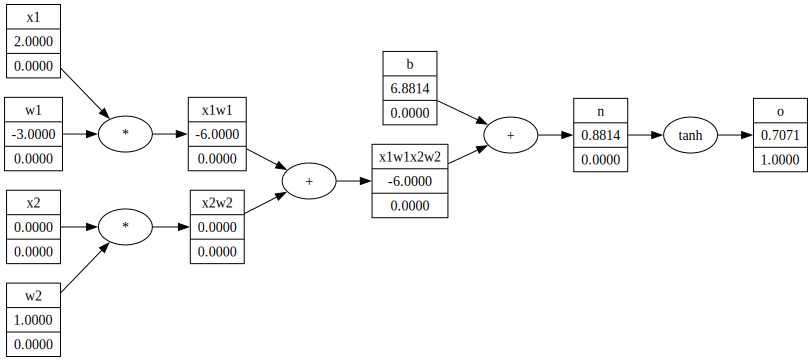

In [39]:
draw_dot(o)

We do not want to do this by hand but rather find a way to loop through our nodes and call the function <code>_backward</code>.
Except that it is not that trivial to *properly* order our nodes. One way to do it is by [topological sort](https://en.wikipedia.org/wiki/Topological_sorting). 

![Topological sort](topological_sort.png)

The topological sorting as well as backpropagation is built in the <code>Value</code> class.

This version of the algorithm uses an iterative version of the *[depth first search](https://en.wikipedia.org/wiki/Depth-first_search)* algorithm.

We can now implement the backpropagation  by calling the <code>._backward</code> on the topologically ordered set of nodes.

In [40]:
o.backward() # Do backpropagation from o

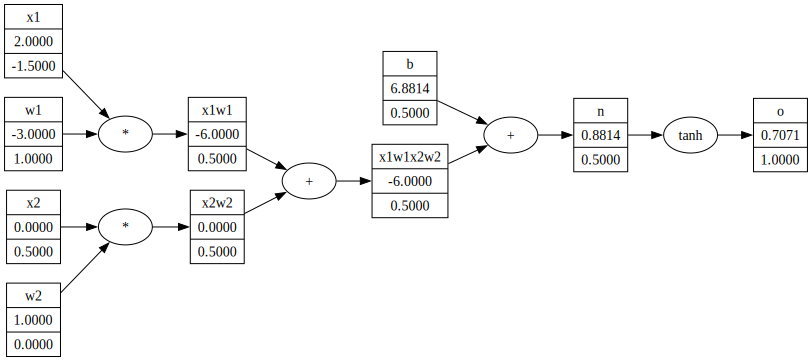

In [41]:
draw_dot(o)

### Autograd in Pytorch

The goal of this section is to show that some modern libraries, like *Pytorch*, do have an autograd engine inside it and hence we can do the very same stuff as with *Micrograd* achieving the same results.

The main differnce is that *Micorgrad* is a scalar valued engine, while in *Pytorch* everything is based on *tensors*, i.e. $n$ dimensional arrays.

In [42]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.881373587019]).double()
b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

# Just like in Micrograd, we have the data attribute as well as the grad attribute!

# Forward pass
print(o.data.item()) # The .item() method just strips out the tensor and returns the value inside it
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Hence, Micrograd is a Pytorch where tensors are just of one element.

### Building an MLP

**Preliminary notation**
- A "*layer*" is just a collection of Neurons.
- "*Hidden*" is because they are between the inputs and the outputs of the neural network, where the actual computations are done.

In neural networks, “MLP” stands for Multi-Layer Perceptron. An MLP is a type of feedforward artificial neural network with one or more hidden layers between the input and output layers, designed to learn complex, non-linear relationships. 

#### Structure
- **Input Layer**: Accepts the data in its raw form.
    - Hidden Layers: Consist of neurons (also called nodes) that apply learned weights and biases followed by an activation function to capture non-linear patterns in the data.
    - Output Layer: Produces the final prediction or classification.
- **Activation Functions**: Each neuron applies a non-linear function, such as ReLU (Rectified Linear Unit) or sigmoid, enabling the network to approximate complex functions.
- **Fully Connected Architecture**: Each neuron in a layer connects to every neuron in the next layer. This allows the MLP to learn intricate patterns, but it also requires more computation as the network deepens.
- **Training**: MLPs use backpropagation and an optimization algorithm (often stochastic gradient descent) to adjust weights and minimize the error between the network’s predictions and the actual labels.

![Structure of a neural network with two hidden layers](nn_scheme.jpeg)

In the figure, the structure of a MLP with two hidden layers. Note that neurons of a given layer are not connected to each other.
Let's recreate the MLP in the picture using the class <code>MLP</code>, implemented in <code>nn.py</code>.

In [ ]:
x = [2.0, 3.0, -1.0] # Input Layer
n = MLP(3, [4, 4, 1]) # 2 hidden layer + 1 output layer, with the two hidden layers bith with 4 neurons
out = n(x)
out

Value(-0.6295150712839195, )

In [44]:
### Tiny dataset

# Inputs
xs = [
   [2.0, 3.0, -1.0],
   [3.0, -1.0, 0.5],
   [0.5, 1.0, 1.0],
   [1.0, 1.0, -1.0] 
]

# Targets
ys = [1.0, -1.0, -1.0, 1.0]

We want to train avery basic neural network on this tiny data set. Given the targets, we want more or less a neural network binary classifier.

Without training, we will get random "trash" results and not the desired labels, as we can see from the following cell.

In [45]:
y_pred = [n(x) for x in xs]
y_pred

[Value(-0.6295150712839195, ),
 Value(-0.9778188952549258, ),
 Value(-0.9228279572909867, ),
 Value(-0.6753649911629882, )]

This is normal as when the MLP is created, by design, its weights and biases have been randomly initialized. We get
$$
n(xs[0]) = -0.91774, \quad \text{while we would want $n(xs[0]) = 1.0$, hence we want to increase the output}
$$
$$
n(xs[1]) = 0.00314, \quad \text{while we would want $n(xs[1]) = -1.0$, hence we want to decrease the output}
$$
$$
n(xs[2]) = -0.37060, \quad \text{while we would want $n(xs[2]) = -1.0$, hence we want to ecrease the output}
$$
$$
n(xs[3]) = -0.84804, \quad \text{while we would want $n(xs[3]) = 1.0$, hence we want to increase the output}
$$
We can fomalise this list of wishes by introducing a mathematical tool measuring the discrepancy between what the MLP structure outputs with the forward pass and our targets. This tool is the *loss function* and *training* the network means *minimising* the (the empirical risk associated to the) loss function, by nudging the weights and biases so that the output they produce through the MLP is "accurate" on our training set.
Here we use the square loss
$$
\begin{align*}
\ell: \mathcal{Y} &\times \mathcal{Y} \to \mathbb{R}^+\\
            (y, &z) \mapsto (z-y)^2.
\end{align*}
$$
Hence the problem we wish to solve is 
$$
\argmin_{\mathbf{w},\mathbf{b}}\hat{\mathcal{R}} = \argmin_{\mathbf{w},\mathbf{b}}\frac{1}{n}\sum_{i = 1}^n (y_{\text{target}} - y_{\text{predicted}})^2,
$$
where
- $(\mathbf{w},\mathbf{b})$ is a (huge) vector containing all the weights and biases.
- $\argmin_{\mathbf{w},\mathbf{b}}\hat{\mathcal{R}}$ means find the vector of weigths and biases minising the empirical risk.
- $y_{\text{predicted}}$ is a function of all the weights and biases being the output of the MLP.

In [46]:
# Compute the empirical risk for the squre loss for your predictions
loss = sum([(y_tgt - y_out)**2 for y_tgt, y_out in zip(ys, y_pred)]) # Here it should rather be "risk", not "loss"
loss

Value(5.468614746739591, )

There is an algoritmic procedure, the *Gradient Descent* that allows us to find that argmin.

Gradient descent is a method for unconstrained mathematical optimization. It is an algorithm for minimizing a differentiable multivariate function.

##### Small description of the gradient descent
Gradient descent is based on the observation that if the multi-variable function $F(\mathbf {x})$ is defined and differentiable in a neighborhood of a point $\mathbf {a}$, then $F(\mathbf {x})$ decreases fastest if one goes from $\mathbf {a}$ in the direction of the negative gradient of 
$F$ at $\mathbf {a} ,-\nabla F(\mathbf {a})$. It follows that, if
$$\mathbf {a} _{n+1}=\mathbf {a} _{n}-\gamma \nabla F(\mathbf {a} _{n})$$
for a small enough step size $\gamma \in \mathbb {R} _{+}$, the **learning rate**, then 
$$F(\mathbf {a_{n}} )\geqslant F(\mathbf {a_{n+1}} ).$$
In other words, the term $\gamma \nabla F(\mathbf {a} )$ is subtracted from $\mathbf {a}$ because we want to move against the gradient, toward the local minimum. With this observation in mind, one starts with a guess $\mathbf {x} _{0}$ for a local minimum of $F$, and considers the sequence 
$$\mathbf {x} _{0},\mathbf {x} _{1},\mathbf {x} _{2},\ldots$$
such that
$$\mathbf {x} _{n+1}=\mathbf {x} _{n}-\gamma _{n}\nabla F(\mathbf {x} _{n}),\ n\geq 0.$$
We have a monotonic sequence
$$F(\mathbf {x} _{0})\geq F(\mathbf {x} _{1})\geq F(\mathbf {x} _{2})\geq \cdots ,$$
so the sequence $(\mathbf {x} _{n})$ converges to the desired local minimum. Note that the value of the step size $\gamma$ is allowed to change at every iteration.

In our case, 
- $\mathbf{x} = (\mathbf{w},\mathbf{b})$
- $F(\mathbf{x}) = \frac{1}{n}\sum_{i = 1}^n (y_{\text{target}} - y_{\text{predicted}})^2$

To implement the gradient descent we need to know $\nabla F(\mathbf{w},\mathbf{b})$ i.e. all the partial derivatives with respect to all the weights and all the biases present in the MLP.

This is where we can resort to the <code>backward</code> function.

In [47]:
loss.backward() # Computes the gradients of evry single node (hence in particular of all the weights and biases through backpropagation).

In [48]:
# For example 
n.layers[0].neurons[0].w[0].grad

-2.617893790132505

For example, we see that this gradient is positive (it might be negative depending on the run), meaning that increasing the weight will increase (decrease if gradient is negative) the loss. Hence, we should decrease (increase if gradient is positive) that weight by a certain amount (which is exactly what the gradient descent is telling us).

In [49]:
### Tiny dataset

# Inputs
xs = [
   [2.0, 3.0, -1.0],
   [3.0, -1.0, 0.5],
   [0.5, 1.0, 1.0],
   [1.0, 1.0, -1.0] 
]

# Targets
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
nb_iterations = 100
learning_rate = 0.1
for k in range(nb_iterations):
    # Forward pass 
    y_pred = [n(x) for x in xs]
    
    loss = sum([(y_tgt - y_out)**2 for y_tgt, y_out in zip(ys, y_pred)]) # Compute the empirical risk
    
    # Backward pass (Backpropagation)
    for p in n.parameters():
        # This is 0-grad in Pytorch
        p.grad = 0.0 # All the grads must be reset to zero! Otherwise, we will be adding grads over and over again when doing the gradient descent
    
    loss.backward() 

    # Update weights (gradient descent) and start over...
    for p in n.parameters():
        p.data -= learning_rate * p.grad
        
    print(k, loss.data)
        
print([n(x) for x in xs])

0 5.468614746739591
1 3.0571454345020994
2 0.3561074758055013
3 0.1416459504830238
4 0.07050802573453356
5 0.05176452839969736
6 0.04151685067596156
7 0.03478348170585949
8 0.02995293705936443
9 0.026298961024005217
10 0.023432300681532747
11 0.021121345202117236
12 0.019218280142741816
13 0.0176238449002447
14 0.01626872302250096
15 0.015102967052909665
16 0.014089643160227266
17 0.013200838271423158
18 0.012415058585078857
19 0.011715482128677833
20 0.011088753993476447
21 0.010524136726816378
22 0.01001289917695393
23 0.009547869064687084
24 0.009123100229078685
25 0.008733621629540236
26 0.008375245574829153
27 0.00804441948363642
28 0.007738110065465531
29 0.007453711939777464
30 0.007188974882037574
31 0.00694194541324723
32 0.006710919539669477
33 0.006494404236959355
34 0.00629108584839452
35 0.006099803991979121
36 0.0059195298883294185
37 0.005749348260069103
38 0.005588442134888078
39 0.005436080023379586
40 0.005291605050030181
41 0.005154425699135495
42 0.00502400790270485